# 전이학습 고양이 강아지 구분
> - https://subinium.github.io/Keras-5-2/

## 전이 학습에 많이 사용되는 세 가지 모델은 다음과 같습니다.
- VGG (예 : VGG16 또는 VGG19).
- GoogLeNet (예 : InceptionV3).
- residual Network (예 : ResNet50).
- 이러한 모델은 성능 때문에 전이 학습에 널리 사용되지만 VGG (일관성 및 반복 구조), 시작 모듈 (GoogLeNet) 및 잔여 모듈 (ResNet)과 같은 특정 아키텍처 혁신을 도입 한 에제임.

## VGG16 (2014)
- 이미지넷으로 사전 훈련된 네트워크를 사용
- 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  

## 1) 특성추출 방식
- 합성곱 필터링 영역(convolutional base)를 그대로 사용
- 공통되는 특성만 추출하여 사용한다
- 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다


## 2) 미세 조정 방식

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/swkim01/DSAC4/blob/main/gg-61-cats_and_dogs_transfer.ipynb"><img src="https://github.com/swkim01/DSAC4/raw/main/colab_logo_32px.png" />구글 코랩에서 실행</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/swkim01/DSAC4/blob/main/gg-61-cats_and_dogs_transfer.ipynb"><img src="https://github.com/swkim01/DSAC4/raw/main/GitHub-Mark-32px.png" />깃헙에서 소스 보기</a>
  </td>
</table>


## 데이터 다운로드

In [2]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import VGG16

## VGG16으로 사전학습된 가중치 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

- VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 이미지에 대해 훈련된 컨벌루션 신경망입니다. 
- 이 네트워크에는 16개의 계층이 있으며, 이미지를 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 
- 그 결과 이 네트워크는 다양한 이미지를 대표하는 다양한 특징을 학습했습니다. 네트워크의 이미지 입력 크기는 224x224입니다.

In [ ]:
conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 특성 추출 방법
### 1) 합성곱 기반을 통과한 출력을 저장한 후 이를 전결합망에 통과
- 데이터 확장은 사용할 수 없다
- 실행이 빠르다

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다


##  Fine Tuning (세부조정) 방법


### 데이터 읽기

In [ ]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   120M      0 --:--:-- --:--:-- --:--:--  120M


In [ ]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (111 kB/s)
Selecting previously unselected package tree.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...


In [ ]:
!tree -d .

.
├── __pycache__
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
├── data
└── lecture

10 directories


In [ ]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_dir

'./cats_and_dogs_filtered/train'

## 특성추출만 사용한 모델 (데이터 증식은 사용하지 않는 방식)
- conv_base layers: 일반적인 학습정보
- final FC layers: 특정한 클라스를 분류하는 기능
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.


In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [ ]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            class_mode='binary',
                                            batch_size=batch_size)
    i=1
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break
            
    print(features.shape, labels.shape) 
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
(2000, 4, 4, 512) (2000,)
Found 1000 images belonging to 2 classes.
(1000, 4, 4, 512) (1000,)


- 추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512)) # 평탄화
validation_features = np.reshape(validation_features, (1000, 4*4*512))

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data= (validation_features, validation_labels),
    batch_size=batch_size)

Epoch 1/30
100/100 [==============================] - 0s 4ms/step - loss: 0.5515 - acc: 0.7220 - val_loss: 0.4143 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3935 - acc: 0.8300 - val_loss: 0.3384 - val_acc: 0.8690
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3260 - acc: 0.8750 - val_loss: 0.3157 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2918 - acc: 0.8795 - val_loss: 0.2992 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2629 - acc: 0.9015 - val_loss: 0.2886 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2305 - acc: 0.9180 - val_loss: 0.2914 - val_acc: 0.8740
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2239 - acc: 0.9180 - val_loss: 0.2760 - val_acc: 0.8840
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

-  두 개의 Dense 층만 처리하면 되기 떄문에 학습이 매우 빠르다.

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

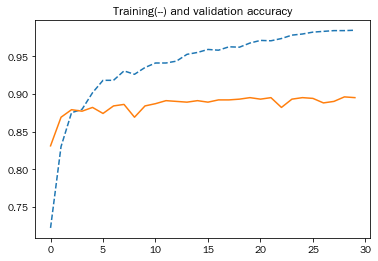

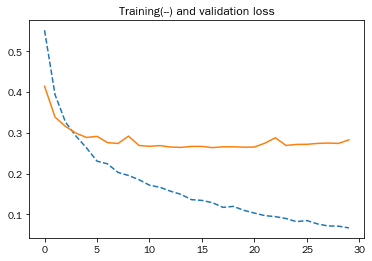

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

### 과대적합이 발생한 것을 알 수 있다.
- 훈련 데이터가 부족하다
- 데이터 확장을 사용하여 개선할 수 있다.

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [ ]:
# 모델

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## 학습을 동결하지 않으면 모두 재 학습된다!

In [ ]:
conv_base.trainable = False

In [ ]:
print(len(model.trainable_weights))

4


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### 컴파일을 수행해야 변경사항이 적용된다

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 과대적합이 줄어든 것을 볼 수 있다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5826 - acc: 0.7110 - val_loss: 0.4366 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 9s 89ms/step - loss: 0.4801 - acc: 0.7785 - val_loss: 0.3664 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 9s 88ms/step - loss: 0.4231 - acc: 0.8255 - val_loss: 0.3304 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.4041 - acc: 0.8250 - val_loss: 0.3149 - val_acc: 0.8610
Epoch 5/30
100/100 [==============================] - 9s 88ms/step - loss: 0.3813 - acc: 0.8325 - val_loss: 0.2985 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 9s 85ms/step - loss: 0.3778 - acc: 0.8380 - val_loss: 0.2969 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 9s 86ms/step - loss: 0.3567 - acc: 0.8395 - val_loss: 0.2840 - val_acc: 

Text(0.5, 1.0, 'Training(--) and validation loss')

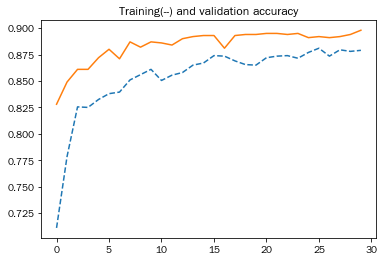

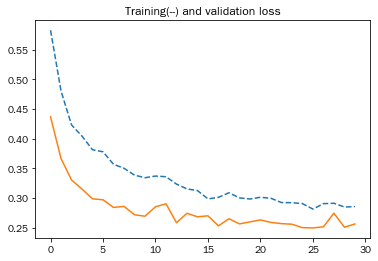

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 미세조정 방법
- 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정이다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)
 - (1)기존 네트워크 상단에 새로운 네트워크 추가한다.
 - (2) 기본 네트워크를 고정시킨다.
 - (3) 새로 추가한 부분을 훈련시킨다.
 - (4) 기본 계층 중에 학습할 상위 부분의 고정을 푼다.
 - (5) 고정을 푼 계층과 새로 추가한 계층을 함께 훈련시킨다.
- 이미 (3) 까지는 전 단계 예제에서 특성 추출할 때 이미 수행이 되어 있기 떄문에 여기서는 (4) 번쨰 단계부터 실행하기만 하면 된다.        

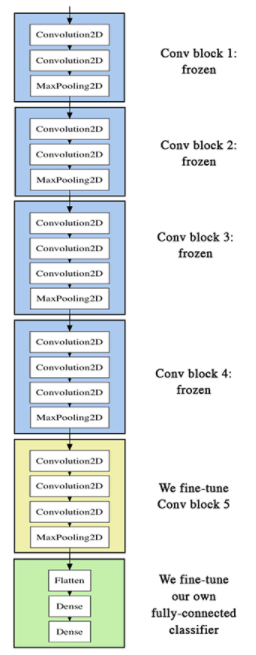

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 위에서 block 5 부분만 미세조정 하겠다

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### 학습률을 작게 조정한다 (천천히 학습하도록)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 9s 91ms/step - loss: 0.3104 - acc: 0.8625 - val_loss: 0.2260 - val_acc: 0.9040
Epoch 2/30
100/100 [==============================] - 9s 86ms/step - loss: 0.2479 - acc: 0.8970 - val_loss: 0.3040 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 8s 85ms/step - loss: 0.2367 - acc: 0.8955 - val_loss: 0.2076 - val_acc: 0.9250
Epoch 4/30
100/100 [==============================] - 8s 85ms/step - loss: 0.2232 - acc: 0.9115 - val_loss: 0.2074 - val_acc: 0.9080
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2023 - acc: 0.9155 - val_loss: 0.2431 - val_acc: 0.9180
Epoch 6/30
100/100 [==============================] - 9s 87ms/step - loss: 0.1931 - acc: 0.9185 - val_loss: 0.2264 - val_acc: 0.9220
Epoch 7/30
100/100 [==============================] - 9s 85ms/step - loss: 0.1689 - acc: 0.9345 - val_loss: 0.2107 - val_acc: 0.9240
Epoch 8/30
100/100 [==============================] - 9s 87ms/step - 

Text(0.5, 1.0, 'Training(--) and validation loss')

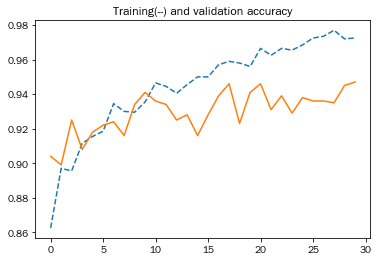

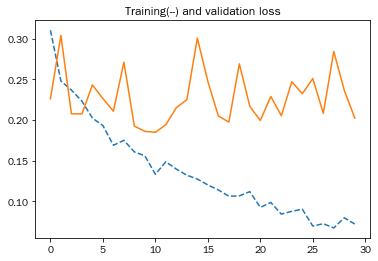

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 성능이 94%로 4% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)
- 정확도에 영향을 미치는 것은 손실값의 분포이지 평균이 아님.
- 지금까지 전체 캐글 경연 데이터의 10%인 2000 개만 사용해서도 높은 성능 결과 없음.

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개

In [ ]:
## 연습 (How to Visualize Filters)
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/